# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset
from countryguess.model import TripletModel
from countryguess.generate import TripletDataset, ValDataset
from countryguess.training import triplet_mining, eval_fn

## Plotting datasets

### Initialise datasets

In [2]:
ref_data = Dataset()
train_data = TripletDataset()
val_data = ValDataset()
test_data = TestDataset()

### Plotting

#### Training data

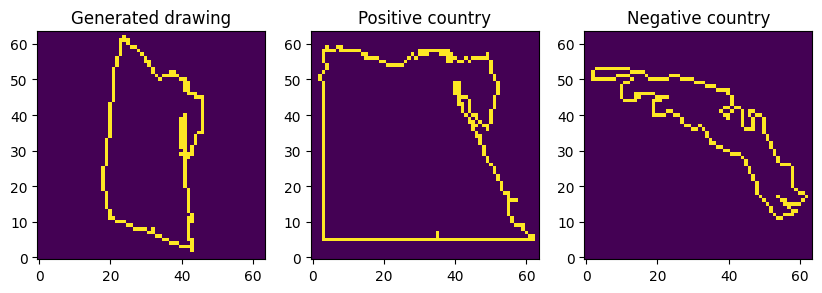

In [3]:
idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]

#Plotting
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title("Generated drawing") 
axs[1].imshow(sample["pos_img"], interpolation='nearest', origin='lower')
axs[1].set_title("Positive country") 
axs[2].imshow(sample["neg_img"], interpolation='nearest', origin='lower')
axs[2].set_title("Negative country") 
plt.show()

#### Validation set

In [5]:
from countryguess.data import poly_to_img

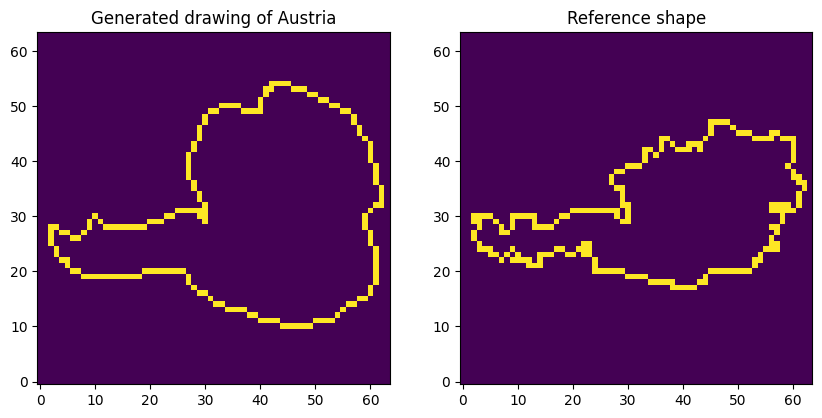

In [6]:
idx = random.randint(0, len(val_data) - 1)
sample = val_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"Generated drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

#### Test set (user drawings)

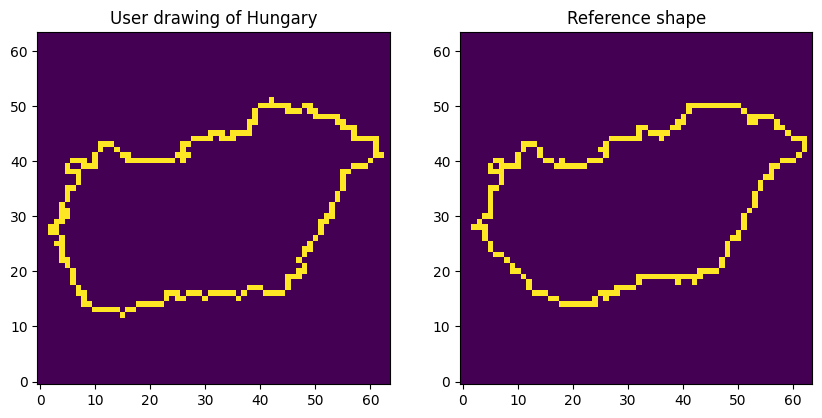

In [8]:
idx = random.randint(0, len(test_data) - 1)
sample = test_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"User drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

## Training model

Run the following command to start the MLFlow Tracking UI: `mlflow ui --port 5001`
<br>Access the MLFlow Tracking UI at: http://127.0.0.1:5001

In [2]:
device = torch.device("mps")

In [23]:
mlflow.set_experiment("local")

params = {"channels": 4*random.randint(1, 6),
          "nr_conv_blocks": random.randint(2, 5),
          "embedding_size": 32*random.randint(2, 7),
          "shape": 32*random.randint(2, 5),
          "learning_rate": random.uniform(0.006, 0.012), 
          "margin": random.uniform(0.5, 1.5),
          "temperature": random.uniform(0.4, 0.8),
          "nr_epochs": random.randint(40, 80)}
print(params)

model = TripletModel(**params).to(device)
#model = torch.compile(model)
optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
triplet_loss = nn.TripletMarginLoss(margin=params['margin'])

{'channels': 20, 'nr_conv_blocks': 4, 'embedding_size': 64, 'shape': 96, 'learning_rate': 0.011791951066111021, 'margin': 1.4044961008513979, 'temperature': 0.5806795422181262, 'nr_epochs': 61}


In [24]:
#Initialise datasets
ref_data = Dataset(shape=(params["shape"], params["shape"]))
train_data = TripletDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])
val_data = ValDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])

train_dl = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_data, batch_size=32, num_workers=2)

In [25]:
with mlflow.start_run() as run:
    mlflow.log_params(params)
    
    #Start training
    for epoch in range(params['nr_epochs']):
        losses = []        
        model.train()
        for batch in train_dl:
            optimizer.zero_grad()
            anc_emb = model(batch['drawing'][:, None, :, :].type(torch.float32).to(device))
            pos_emb = model(batch['pos_img'][:, None, :, :].type(torch.float32).to(device))
            neg_emb = model(batch['neg_img'][:, None, :, :].type(torch.float32).to(device))
    
            #Mine triplets
            anc_emb, pos_emb, neg_emb = triplet_mining(anc_emb, pos_emb, neg_emb, 
                                                       batch["pos_idx"], batch["neg_idx"])
    
            loss = triplet_loss(anc_emb, pos_emb, neg_emb)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
    
        mlflow.log_metric("loss", np.mean(losses), epoch)
        
        print('Epoch: {}/{}\t loss: {:.3f}'.format(epoch+1, params['nr_epochs'], np.mean(losses)))
    
        if (epoch+1)%5==0:
            ranking = np.array([])
            model.eval()
            model.load_reference(ref_data)
            for batch in val_dl:
                rank = eval_fn(model, batch)
                ranking = np.append(ranking, rank)
    
            mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
            mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
            mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)
    
            print('Epoch: {}/{}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
                  .format(epoch+1, params['nr_epochs'], np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1)))

Epoch: 1/61	 loss: 0.382
Epoch: 2/61	 loss: 0.174
Epoch: 3/61	 loss: 0.064
Epoch: 4/61	 loss: 0.081
Epoch: 5/61	 loss: 0.092
Epoch: 5/61	 Average rank: 4.80	 top 10 acc: 91.4%	 top 1 acc: 66.0%	
Epoch: 6/61	 loss: 0.032
Epoch: 7/61	 loss: 0.072
Epoch: 8/61	 loss: 0.021
Epoch: 9/61	 loss: 0.189
Epoch: 10/61	 loss: 0.233
Epoch: 10/61	 Average rank: 3.48	 top 10 acc: 93.9%	 top 1 acc: 70.1%	
Epoch: 11/61	 loss: 0.076
Epoch: 12/61	 loss: 0.041
Epoch: 13/61	 loss: 0.055
Epoch: 14/61	 loss: 0.088
Epoch: 15/61	 loss: 0.044
Epoch: 15/61	 Average rank: 3.76	 top 10 acc: 92.9%	 top 1 acc: 59.4%	
Epoch: 16/61	 loss: 0.099
Epoch: 17/61	 loss: 0.034
Epoch: 18/61	 loss: 0.058
Epoch: 19/61	 loss: 0.039
Epoch: 20/61	 loss: 0.016
Epoch: 20/61	 Average rank: 2.22	 top 10 acc: 97.0%	 top 1 acc: 73.1%	
Epoch: 21/61	 loss: 0.029
Epoch: 22/61	 loss: 0.048
Epoch: 23/61	 loss: 0.035
Epoch: 24/61	 loss: 0.042
Epoch: 25/61	 loss: 0.042
Epoch: 25/61	 Average rank: 3.28	 top 10 acc: 97.0%	 top 1 acc: 69.0%	
Epoch

### Evaluate model

In [26]:
test_data = TestDataset(shape=(params["shape"], params["shape"]))
test_dl = DataLoader(test_data, batch_size=32)

In [27]:
ranking = np.array([])
model.load_reference(ref_data)
model.eval()
country_names = []
for batch in test_dl:
    rank = eval_fn(model, batch)
    ranking = np.append(ranking, rank)
    country_names.extend(batch['country_name'])
    
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric("nr_test_samples", len(test_data))
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [28]:
print('Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
      .format(np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1))) 

Average rank: 4.40	 top 10 acc: 88.6%	 top 1 acc: 51.4%	


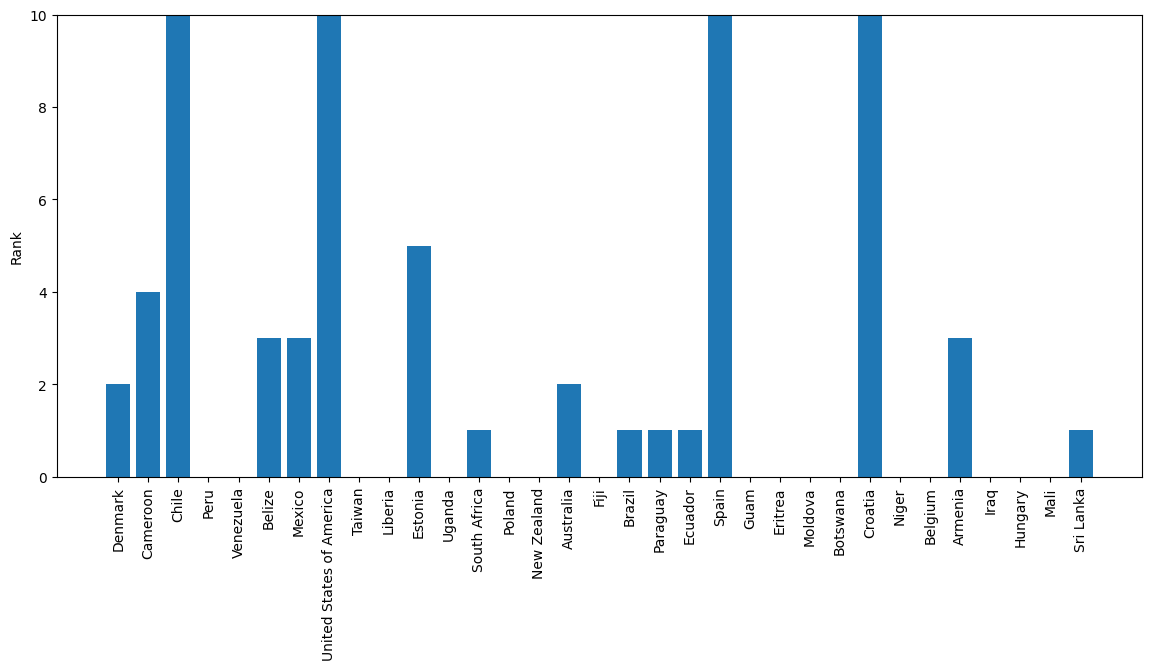

In [29]:
fig = plt.figure(figsize = (14, 6))
plt.bar(country_names, ranking)
plt.xticks(rotation=90)
plt.ylim((0, 10))
plt.ylabel("Rank")
plt.show()

### Log model

In [12]:
#mlflow.set_tracking_uri("file:./mlruns")
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.pytorch.log_model(model, "model")